# Dependencies

In [1]:
# !pip install pandas
# !pip install transformers
# !pip install --upgrade jupyter ipywidgets
# !pip install torch torchvision torchaudio
# !pip install tensorflow
# !pip install flax
# !pip install evaluate

# Import data

In [2]:
import pandas as pd

data = pd.read_csv("dataset/small_data_sample.csv")
data

,text,label
0,"Explosion Rocks Baghdad Neighborhood BAGHDAD, ...",0
1,BBC reporters' log BBC correspondents record e...,0
2,Israel welcomes Rice nomination; Palestinians ...,0
3,Medical Journal Calls for a New Drug Watchdog ...,0
4,Militants Kidnap Relatives of Iraqi Minister-T...,0
...,...,...
39995,Microsoft Tests MSN Messenger 7.0 Updated chat...,3
39996,Vonage talks of 911 advancements In Rhode Isla...,3
39997,Exploring Venus: The Hothouse Planet Before sp...,3
39998,PayPal to Impose Fines for Breaking Bans - On...,3


---

In [3]:
from datasets import Dataset

dataset_hf = Dataset.from_pandas(data)

In [4]:
from datasets import DatasetDict

# 80% train + validation, 20% test
train_test = dataset_hf.train_test_split(test_size=0.2, seed=42)

# Split the 80% train+validation set in 90% train, 10% validation
train_valid = train_test['train'].train_test_split(test_size=0.1)

train_valid_test_dataset = DatasetDict({
    'train': train_valid['train'],
    'test': train_test['test'],
    'validation': train_valid['test']
})

---

| Model Label | Model Label Value | -> | Data Label | Data Label Value |
| -------- | -------- | -------- | -------- | -------- |
| 0 | Sports | -> | 1 | Sports |
| 1 | Arts, Culture, and Entertainment | -> | 0 | World |
| 2 | Business and Finance | -> | 2 | Business |
| 3 | Health and Wellness | -> | 0 | World |
| 4 | Lifestyle and Fashion | -> | 0 | World |
| 5 | Science and Technology | -> | 3 | Sci/Tech |
| 6 | Politics | -> | 0 | World |
| 7 | Crime | -> | 0 | World |

In [5]:
label_converter = {
    0: 1,
    1: 0,
    2: 2,
    3: 0,
    4: 0,
    5: 3,
    6: 0,
    7: 0
}

In [6]:
label_dict = {
    0: 'World', 
    1: 'Sports', 
    2: 'Business',
    3: 'Sci/Tech'
}

In [7]:
model_name = "dstefa/roberta-base_topic_classification_nyt_news"

predictions_dict = {
    "Sports": 1,
    "Arts, Culture, and Entertainment": 0,
    "Business and Finance": 2,
    "Health and Wellness": 0,
    "Lifestyle and Fashion": 0,
    "Science and Technology": 3,
    "Politics": 0,
    "Crime": 0
}

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_metrics(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='macro'))
    print('Recall: ', recall_score(y_test, y_pred, average='macro'))
    print('F1: ', f1_score(y_test, y_pred, average='macro'))

# Transformer

In [9]:
from transformers import pipeline

classifier = pipeline(model=model_name)

2024-05-01 16:05:23.183095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
from sklearn.metrics import classification_report

sample = train_valid_test_dataset['test'][:1000] #TODO: Use all data
predictions = [classifier(sample_row)[0]['label'] for sample_row in sample['text']]
converted_predictions = [predictions_dict[entry] for entry in predictions]
real_values = [int(actual_label) for actual_label in sample['label']]
print(classification_report(real_values, converted_predictions))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       209
           1       0.94      0.95      0.94       277
           2       0.56      0.93      0.70       241
           3       0.90      0.29      0.44       273

    accuracy                           0.74      1000
   macro avg       0.78      0.75      0.71      1000
weighted avg       0.80      0.74      0.71      1000



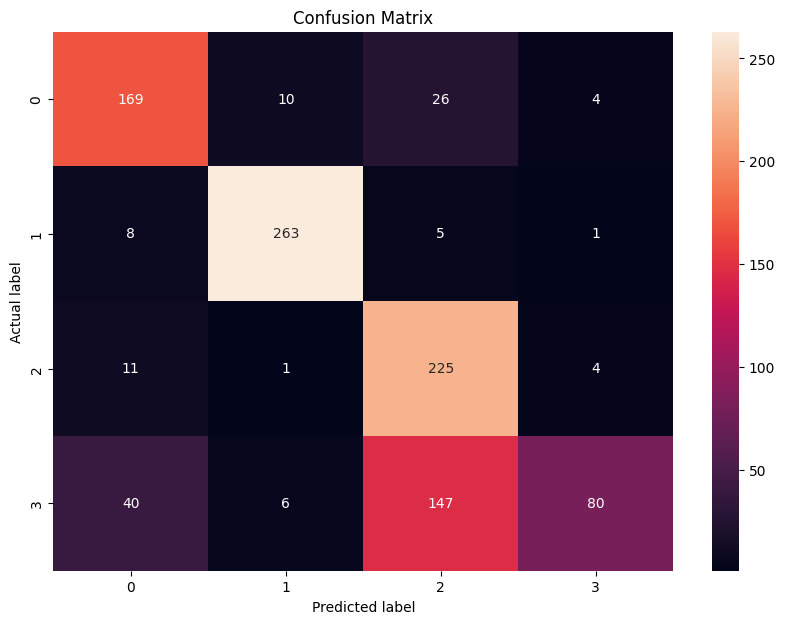

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(real_values, converted_predictions)

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Fine-tuning 

## Tokenize dataset

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [48]:
def preprocess_function(sample):
    return tokenizer(sample["text"], truncation=True)

In [49]:
tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/28800 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 28800
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3200
    })
})

## Finetune the model

In [50]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from evaluate import load
import numpy as np

metric = load("accuracy")

def compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    print(predictions)
    predictions_converted = [label_converter[entry] for entry in predictions]
    # print(predictions_converted)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [51]:
trainer.train()

  0%|          | 0/5400 [00:00<?, ?it/s]

{'loss': 0.5728, 'grad_norm': 5.399385452270508, 'learning_rate': 1.814814814814815e-05, 'epoch': 0.28}
{'loss': 0.3616, 'grad_norm': 11.400710105895996, 'learning_rate': 1.6296296296296297e-05, 'epoch': 0.56}
{'loss': 0.3228, 'grad_norm': 3.186119556427002, 'learning_rate': 1.4444444444444446e-05, 'epoch': 0.83}


  0%|          | 0/200 [00:00<?, ?it/s]

[3 3 2 ... 0 2 0]
{'eval_loss': 0.29950451850891113, 'eval_accuracy': 0.90375, 'eval_runtime': 6.1046, 'eval_samples_per_second': 524.191, 'eval_steps_per_second': 32.762, 'epoch': 1.0}
{'loss': 0.2907, 'grad_norm': 2.831228494644165, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}
{'loss': 0.277, 'grad_norm': 7.143630504608154, 'learning_rate': 1.0740740740740742e-05, 'epoch': 1.39}
{'loss': 0.2632, 'grad_norm': 3.630972385406494, 'learning_rate': 8.888888888888888e-06, 'epoch': 1.67}
{'loss': 0.2701, 'grad_norm': 9.039741516113281, 'learning_rate': 7.0370370370370375e-06, 'epoch': 1.94}


  0%|          | 0/200 [00:00<?, ?it/s]

[3 3 2 ... 0 2 0]
{'eval_loss': 0.30397310853004456, 'eval_accuracy': 0.915625, 'eval_runtime': 6.071, 'eval_samples_per_second': 527.092, 'eval_steps_per_second': 32.943, 'epoch': 2.0}
{'loss': 0.2222, 'grad_norm': 3.504011869430542, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}
{'loss': 0.226, 'grad_norm': 4.562679767608643, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}
{'loss': 0.2251, 'grad_norm': 1.231864094734192, 'learning_rate': 1.4814814814814815e-06, 'epoch': 2.78}


  0%|          | 0/200 [00:00<?, ?it/s]

[3 3 2 ... 0 2 0]
{'eval_loss': 0.2931508719921112, 'eval_accuracy': 0.9165625, 'eval_runtime': 6.091, 'eval_samples_per_second': 525.369, 'eval_steps_per_second': 32.836, 'epoch': 3.0}
{'train_runtime': 650.9782, 'train_samples_per_second': 132.723, 'train_steps_per_second': 8.295, 'train_loss': 0.2987599210385923, 'epoch': 3.0}


TrainOutput(global_step=5400, training_loss=0.2987599210385923, metrics={'train_runtime': 650.9782, 'train_samples_per_second': 132.723, 'train_steps_per_second': 8.295, 'total_flos': 3629187619470336.0, 'train_loss': 0.2987599210385923, 'epoch': 3.0})

In [52]:
trainer.evaluate()

  0%|          | 0/200 [00:00<?, ?it/s]

[3 3 2 ... 0 2 0]


{'eval_loss': 0.2931508719921112,
 'eval_accuracy': 0.9165625,
 'eval_runtime': 6.138,
 'eval_samples_per_second': 521.341,
 'eval_steps_per_second': 32.584,
 'epoch': 3.0}

In [56]:
predictions = trainer.predict(test_dataset=tokenized_dataset["test"]) 

  0%|          | 0/500 [00:00<?, ?it/s]

[3 1 1 ... 2 2 3]


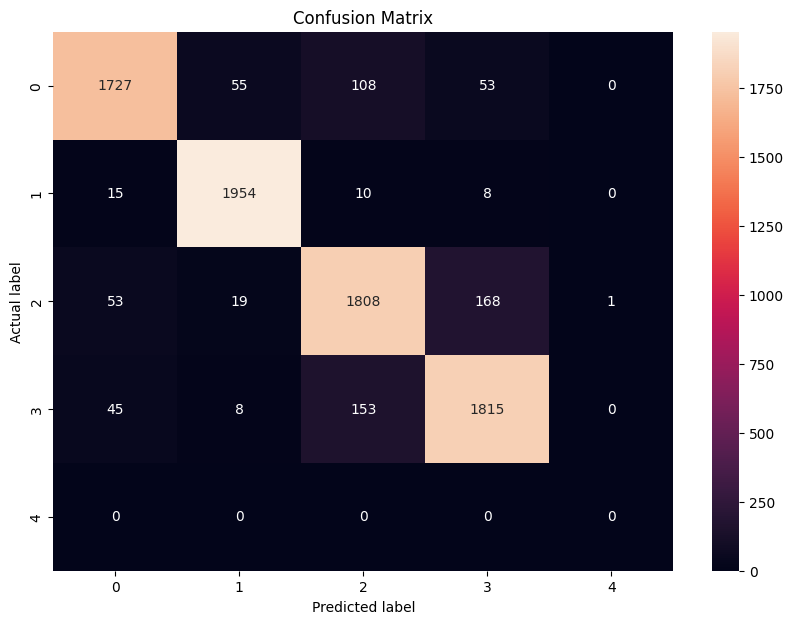

In [58]:
import numpy as np


# The predictions are in a tuple, with the first element being the actual predictions
predicted_labels = np.argmax(predictions[0], axis=1)

# Assuming the labels in your dataset are stored in a 'label' column
true_labels = [entry['label'] for entry in tokenized_dataset['test']]

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Save the model

In [54]:
trainer.save_model()